In [17]:
# General imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import collections
import os
import time
import re
import itertools

# Data Science
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Natural Language processing
import nltk

## Stemming
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

# Learning Algorithms / estimators
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer, confusion_matrix

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Process
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.pipeline import Pipeline

# Plotting
from matplotlib.markers import MarkerStyle
from PIL import Image

# Corpus
from documentModel import DocumentModel as DM
from export_results import *
from utils import *

In [19]:
def total_cost_ratio(ground_truth = None, predictions = None, price = 1):
    n_expensive = np.array(np.nonzero(ground_truth)).size
    cm = confusion_matrix(ground_truth, predictions)
    n_fp = cm[0][1]
    n_fn = cm[1][0]
    
    return n_expensive/(price * n_fp + n_fn)

def save_image(image, url='../images/', name = 'default'):
    image.savefig(url + name)
    Image.open(url + name + '.png').convert('L').save(url + name + '.png')
    
def plot_image(x, y, title="title", ylim = [0, 1.02], xlim = [2, 50.5], 
               colors="rgbmyc", models=None, name="name", labels=[], ylabel = "ylabel", 
               loc="better", markers=".,ov<>", pattern=""):
    plt.figure(figsize=(14,13))
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel("Misclassification Cost Ratio")
    plt.ylabel(ylabel)
    plt.style.use('paper.mplstyle')
    
    filled_markers = ('<', 'D', 'o', '|', 'v', '>', 'p', 'd') #' '^', ', '>', '8', 's', 'p', '*', 'h', 'H', , 'd')
    fillstyles = ('full', 'full', 'full', 'full', 'top', 'none')

    i = 0
    for model in models:
        model_name = model[0]
        if re.match(pattern, model_name) is not None:
            plt.plot(x, y[model_name])
            marker = MarkerStyle(marker=filled_markers[i], fillstyle=fillstyles[i])
            plt.scatter(x, y[model_name], marker=marker, s=300, label=model[0])
            i+=1
    
    plt.xticks(x, labels, rotation='vertical')
    plt.legend(loc=loc, prop={'size':30})

    save_image(plt,'../images/', name)
    plt.show()
    
def filter_results(recalls, precisions, models=None, pattern=".*"):

    recalls_avg = {}
    precisions_avg = {}

    for model in models:
        name = model[0]
        if re.match(pattern, name) is not None:
            recalls_avg[name] = recalls[name]
            precisions_avg[name] = precisions[name]
    
    return recalls_avg, precisions_avg
    
def normalize(recall_avg, precision_avg):
    recall_avg_normalized = {}

    for key, value in recall_avg.items():
        recall_avg_normalized[key] = []

    for key, values in recall_avg.items():
        for value in values:
            recall_avg_normalized[key].append(float(value * 100))
 

    precision_avg_normalized = {}

    for key, value in precision_avg.items():
        precision_avg_normalized[key] = []

    for key, values in precision_avg.items():
        for value in values:
            precision_avg_normalized[key].append(float(value * 100)) 
            
    return recall_avg_normalized, precision_avg_normalized

def set_baseline(name):
    recall_baseline = recall_avg_normalized[name]
    precision_baseline = precision_avg_normalized[name]
    
    return recall_baseline, precision_baseline

#".*Stemming.*(Bayes|SVM)"    
def summary(recalls, precisions, pattern=".*"):
    r, p = filter_results(recalls, precisions, pipes, pattern) 
    max_recall = 0.0
    best_precision = 0.0
    best_cost = "1:1"
    best_algorithm = ''

    for (name, recalls), (name_2, precisions) in zip(r.items(), p.items()):
        print("Executing: " + name + " ...")
        recs = []
        pres = []
        recs.append(np.mean(recalls))
        pres.append(np.mean(precisions))
        for i, (recall, precision) in enumerate(zip(recalls, precisions)):
            if recall > max_recall:
                best_cost = labels[i]
                max_recall = recall
                best_precision = precisions[i]
                best_algorithm = name
            if recall == max_recall and precision > best_precision:
                best_cost = labels[i]
                max_recall = recall
                best_precision = precisions[i]
                best_algorithm = name
                
    return best_cost, max_recall, best_precision, best_algorithm, np.mean(recs), np.mean(pres) 

def write_results(name, precision, recall):
    import pymysql.cursors

    connection = pymysql.connect(host='localhost',
                             user='root',
                             password='',
                             db='agriculture_experiments',
                             charset='utf8')

    try:
        with connection.cursor() as cursor:
            sql = "INSERT INTO results(name, prec, recall) VALUES(%s, %s, %s)"
            cursor.execute(sql, (name, str(precision).strip('[]'), str(recall).strip('[]')))
            connection.commit()
    
    except Exception as e:
        print(e)
    finally:
        connection.close()
        
def load_results():
    import pymysql.cursors

    precisions = {}
    recalls = {}
    connection = pymysql.connect(host='localhost',
                             user='root',
                             password='',
                             db='agriculture_experiments',
                             charset='utf8')
    results = []

    try:
        with connection.cursor() as cursor:
            sql = "SELECT * FROM results"
            cursor.execute(sql)
            results = cursor.fetchall()
    except Exception as e:
        print(e)
    finally:
        connection.close()
        
    for result in results:
        pres = [float(res) * 100 for res in result[1].split(',')]
        recs = [float(res) * 100 for res in result[2].split(',')]
        precisions[result[0]] = pres
        recalls[result[0]] = recs
        
    return recalls, precisions

In [20]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = SnowballStemmer(language="spanish")
    
    def __call__(self, doc):
        return [self.wnl.stem(t) for t in word_tokenize(doc)]

In [35]:
def init():
    recall_avg = {}
    recall_std = {}
    tcr_1_avg = {}
    tcr_9_avg = {}
    tcr_99_avg = {}
    precision_avg = {}
    precision_std = {}
    pipelines = []

    for element in itertools.product(estimators, nlp):
        name = element[1][0] + '-' + element[0][0]
        pipeline = Pipeline([('nlp', element[1][1]), ('clf', element[0][1])])
        pipelines.append((name , pipeline))
        recall_avg[name] = []
        precision_avg[name] = []
        recall_std[name] = []
        precision_std[name] = []
        tcr_1_avg[name] = []
        tcr_9_avg[name] = []
        tcr_99_avg[name] = []
        
    return pipelines, recall_avg, recall_std , precision_avg, precision_std, tcr_1_avg, tcr_9_avg, tcr_99_avg

# Business Rule Classification

In [36]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

print("OK")

Transforming annotated files into training datasets...
OK


## NLP Exploration

In [37]:
rule_data = pd.DataFrame({"rule": X, "tag": y})
permissions = rule_data[rule_data["tag"] == 0]
prohibitions = rule_data[rule_data["tag"] == 1]

In [38]:
permissions.head()

rule  tag
0   Aplicar sobre el suelo en pequeños montones o ...    0
3   Aplicar en pulverización normal, variando la d...    0
4   En la etiqueta deberán figurar las instruccion...    0
9   Aplicar en pulverización normal, dependiendo d...    0
14                    Aplicar en pulverización normal    0

In [39]:
prohibitions.head()

rule  tag
1  Evitar que el producto caiga sobre las plantas...    1
2  Advertir en la etiqueta que es peligroso para ...    1
5  No mezclar con aceites ni productos de reacció...    1
6  No aplicar aceites minerales durante los 21 dí...    1
7  No aplicar en cultivos cuyos frutos sean desti...    1

## Experiment Variables

In [40]:
labels = ["1:1","1:2","1:4","1:6","1:10","1:25", "1:50", r"1:$10^2$", r"1:$10^3$", r"1:$10^6$"]
# like the ShuffleSplit strategy, stratified random splits do not guarantee 
#that all folds will be different, although this is still very likely for sizeable datasets
sss = StratifiedKFold(y, n_folds = 10, random_state = 2016)
costs = np.array([2, 3, 4, 6, 10, 25, 50, 100, 1000, 1000000])
axis_costs = np.arange(1,11,1)
cxlim = [0.8, 10.15]
estimators = [("Naive Bayes", MultinomialNB(fit_prior=False)), 
              ("Random Forest", RandomForestClassifier(n_estimators=20)), 
              ("SVM", SVC(kernel='linear', C = 0.1)),
              ("Baseline", DummyClassifier(strategy = "constant", constant=1))]

nlp = [("None", TfidfVectorizer(use_idf = True, stop_words=stop_words)),
       ("Stemming", TfidfVectorizer(use_idf = True, stop_words=stop_words, tokenizer=LemmaTokenizer())), 
       ("Bigrams", TfidfVectorizer(use_idf = True, stop_words=stop_words, ngram_range=(2, 2))), 
       ("Combination", TfidfVectorizer(use_idf = True, stop_words=stop_words, ngram_range=(1, 2)))]

In [43]:
pipes, _, _, _, _, _, _, _ = init()


## Main Experiment Loop

In [11]:
def experiment(pattern = ".*", to_normalize = True, dump = False):

    t0 = time.time()
    pipes, recall_avg, recall_std, precision_avg, precision_std = init()

    for estimator in pipes:
        name = estimator[0]
        if re.match(pattern, name) is not None:
            print("Trying: " + name + " ...")
            for cost in costs:
                extractor = estimator[1].steps[0][1].fit(X)
                if "Naive Bayes" in name:
                    model = estimator[1].set_params(clf__class_prior=[1/cost, (cost-1)/cost]).steps[1][1]
                elif "Random Forest" in name:
                    model = estimator[1].set_params(clf__class_weight={1:cost-1}).steps[1][1]
                elif "SVM" in name:
                    model = estimator[1].set_params(clf__class_weight={1:cost-1}).steps[1][1]
                elif "Baseline" in name:
                    model = estimator[1].steps[1][1]
            
                precisions = []
                recalls = []
                for train_index, test_index in sss:
                    X_train, X_test = \
                        extractor.transform(X)[train_index], extractor.transform(X)[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    model.fit(X_train, y_train)
                    precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
                    recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
                recall_avg[name].append(np.average(recalls))
                recall_std[name].append(np.std(recalls))
                precision_avg[name].append(np.average(precisions))
                precision_std[name].append(np.std(precisions))
            if dump == True:
                write_results(name, precision_avg[name], recall_avg[name])
                
    t1 = time.time()
    print()
    print("Execution time: %.3f min" % ((t1 - t0)/60))
    
    if to_normalize == True:
        recall_avg_normalized, precision_avg_normalized = normalize(recall_avg, precision_avg)
        return recall_avg_normalized, precision_avg_normalized
    
    return recall_avg, precision_avg

In [ ]:
#recall_avg_normalized, precision_avg_normalized = experiment(dump = True)     
recall_avg_normalized, precision_avg_normalized = load_results()

In [59]:
def experiment_tcr(pattern = ".*", to_normalize = True, dump = False):
    
    tcr_1 = make_scorer(total_cost_ratio, price = 1, greater_is_better=True)
    tcr_9 = make_scorer(total_cost_ratio, price = 9, greater_is_better=True)
    tcr_99 = make_scorer(total_cost_ratio, price = 99, greater_is_better=True)

    t0 = time.time()
    pipes, recall_avg, recall_std, precision_avg, precision_std, tcr_1_avg, tcr_9_avg, tcr_99_avg = init()

    for estimator in pipes:
        name = estimator[0]
        if re.match(pattern, name) is not None:
            print("Trying: " + name + " ...")
            for cost in costs:
                extractor = estimator[1].steps[0][1].fit(X)
                if "Naive Bayes" in name:
                    model = estimator[1].set_params(clf__class_prior=[1/cost, (cost-1)/cost]).steps[1][1]
                elif "Random Forest" in name:
                    model = estimator[1].set_params(clf__class_weight={1:cost-1}).steps[1][1]
                elif "SVM" in name:
                    model = estimator[1].set_params(clf__class_weight={1:cost-1}).steps[1][1]
                elif "Baseline" in name:
                    model = estimator[1].steps[1][1]
            
                tcrs_1 = []
                tcrs_9 = []
                tcrs_99 = []
                for train_index, test_index in sss:
                    X_train, X_test = \
                        extractor.transform(X)[train_index], extractor.transform(X)[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    model.fit(X_train, y_train)
                    tcrs_1.append(tcr_1(model, X_test, y_test))
                    tcrs_9.append(tcr_9(model, X_test, y_test))
                    tcrs_99.append(tcr_99(model, X_test, y_test))
                tcr_1_avg[name].append(np.average(tcrs_1))
                tcr_9_avg[name].append(np.average(tcrs_9))
                tcr_99_avg[name].append(np.average(tcrs_99))
            if dump == True:
                write_results(name, precision_avg[name], recall_avg[name])
                
    t1 = time.time()
    print()
    print("Execution time: %.3f min" % ((t1 - t0)/60))
    
    
    return tcr_1_avg, tcr_9_avg, tcr_99_avg

In [61]:
tcr_1_avg, tcr_9_avg, tcr_99_avg = experiment_tcr(pattern = ".*Bayes.*", dump = False)

Trying: None-Naive Bayes ...
Trying: Stemming-Naive Bayes ...
Trying: Bigrams-Naive Bayes ...
Trying: Combination-Naive Bayes ...

Execution time: 2.500 min


In [66]:
tcr_99_avg

{'Bigrams-Baseline': [],
 'Bigrams-Naive Bayes': [0.030857873347318349,
  0.013859075848293176,
  0.010912836455511632,
  0.0095835874643909573,
  0.0082843333112548358,
  0.0072370738185821067,
  0.0069395866524754879,
  0.0065106358461906209,
  0.0053205855344892776,
  0.0053205855344892776],
 'Bigrams-Random Forest': [],
 'Bigrams-SVM': [],
 'Combination-Baseline': [],
 'Combination-Naive Bayes': [0.042951842899519359,
  0.016564622509632441,
  0.013783931616241165,
  0.011893956629882428,
  0.0099815774000556606,
  0.0080873847854293045,
  0.0075215629703876009,
  0.0070984290048662271,
  0.0053205855344892776,
  0.0053205855344892776],
 'Combination-Random Forest': [],
 'Combination-SVM': [],
 'None-Baseline': [],
 'None-Naive Bayes': [0.038236122382641215,
  0.019103278750036638,
  0.014883307016427341,
  0.012078829062215123,
  0.0099617048571551924,
  0.0079957201263629405,
  0.0072256895975754253,
  0.0060497698297407414,
  0.0053205855344892776,
  0.0053205855344892776],
 'No

## All classifiers

In [13]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*")

Executing: Combination-Naive Bayes ...
Executing: Bigrams-Naive Bayes ...
Executing: Stemming-Baseline ...
Executing: Bigrams-Baseline ...
Executing: Combination-Baseline ...
Executing: None-Baseline ...
Executing: None-Random Forest ...
Executing: None-SVM ...
Executing: None-Naive Bayes ...
Executing: Bigrams-SVM ...
Executing: Stemming-Naive Bayes ...
Executing: Bigrams-Random Forest ...
Executing: Combination-SVM ...
Executing: Combination-Random Forest ...
Executing: Stemming-SVM ...
Executing: Stemming-Random Forest ...


In [14]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:10
100.0
44.718557180116036
Bigrams-Naive Bayes
86.7777777778
84.3381594202


## Bayes

In [15]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*Bayes")

Executing: Combination-Naive Bayes ...
Executing: Bigrams-Naive Bayes ...
Executing: None-Naive Bayes ...
Executing: Stemming-Naive Bayes ...


In [16]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:10
100.0
44.718557180116036
Bigrams-Naive Bayes
98.568627451
48.7874040065


## SVM

In [97]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*SVM")

Executing: None-SVM ...
Executing: Stemming-SVM ...
Executing: Bigrams-SVM ...
Executing: Combination-SVM ...


In [98]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:6
99.41176470588235
51.59298770001042
Bigrams-SVM
91.4738562092
64.3826920552


## Random Forest

In [99]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*Random.*")

Executing: Bigrams-Random Forest ...
Executing: Stemming-Random Forest ...
Executing: None-Random Forest ...
Executing: Combination-Random Forest ...


In [100]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:$10^2$
93.75816993464052
73.4244596903399
Combination-Random Forest
88.0588235294
82.6995222678


## No preprocessing Step

In [101]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*None.*(Bayes|SVM|.*Forest)")

Executing: None-SVM ...
Executing: None-Random Forest ...
Executing: None-Naive Bayes ...


In [102]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:25
100.0
44.00633773308192
None-Naive Bayes
98.7973856209
48.9389819863


## Bigrams

In [103]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*Bigra.*(Bayes|SVM|.*Forest)")

Executing: Bigrams-Random Forest ...
Executing: Bigrams-SVM ...
Executing: Bigrams-Naive Bayes ...


In [104]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:10
100.0
44.718557180116036
Bigrams-Naive Bayes
99.362745098
45.8460064913


## Combining bigrams and unigrams

In [105]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*Comb.*(Bayes|SVM|.*Forest)")

Executing: Combination-Random Forest ...
Executing: Combination-SVM ...
Executing: Combination-Naive Bayes ...


In [106]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:25
100.0
44.251912831181116
Combination-Naive Bayes
98.9673202614
48.9234072084


## Plot best results

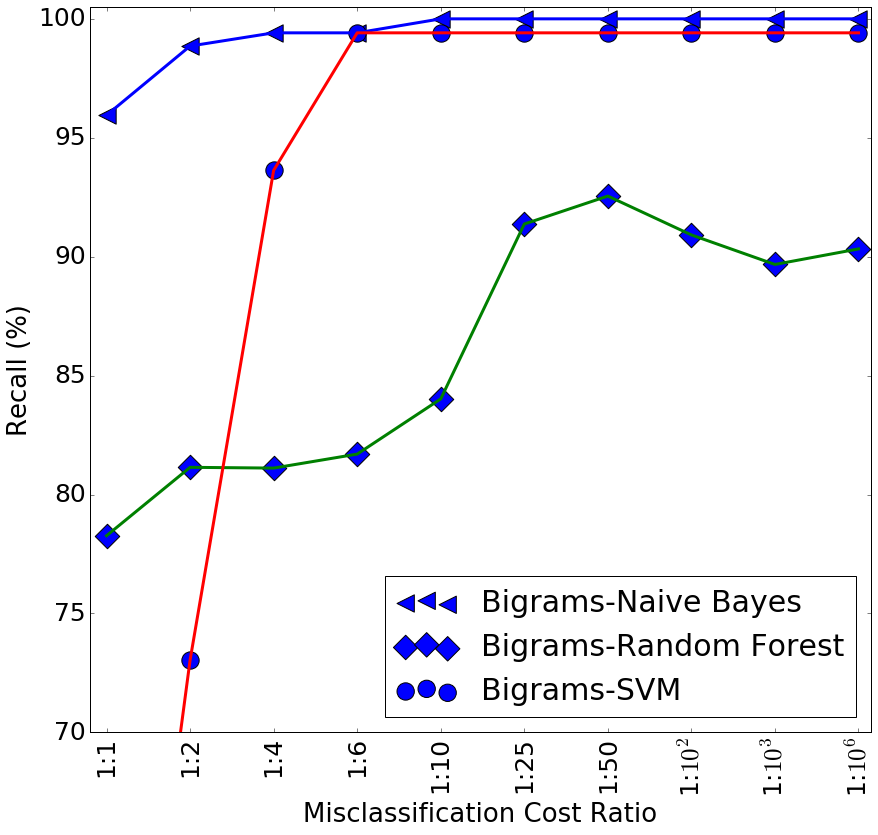

In [107]:
plot_image(axis_costs, recall_avg_normalized, title="RECALL", ylim = [70., 100.5], 
           xlim = cxlim, models=pipes, name="recall", labels=labels, ylabel="Recall (%)", 
           loc='lower righ', markers="<Do|", pattern="(.*Bigram.*(Bayes|SVM|.*Forest)|None_Baseline)")

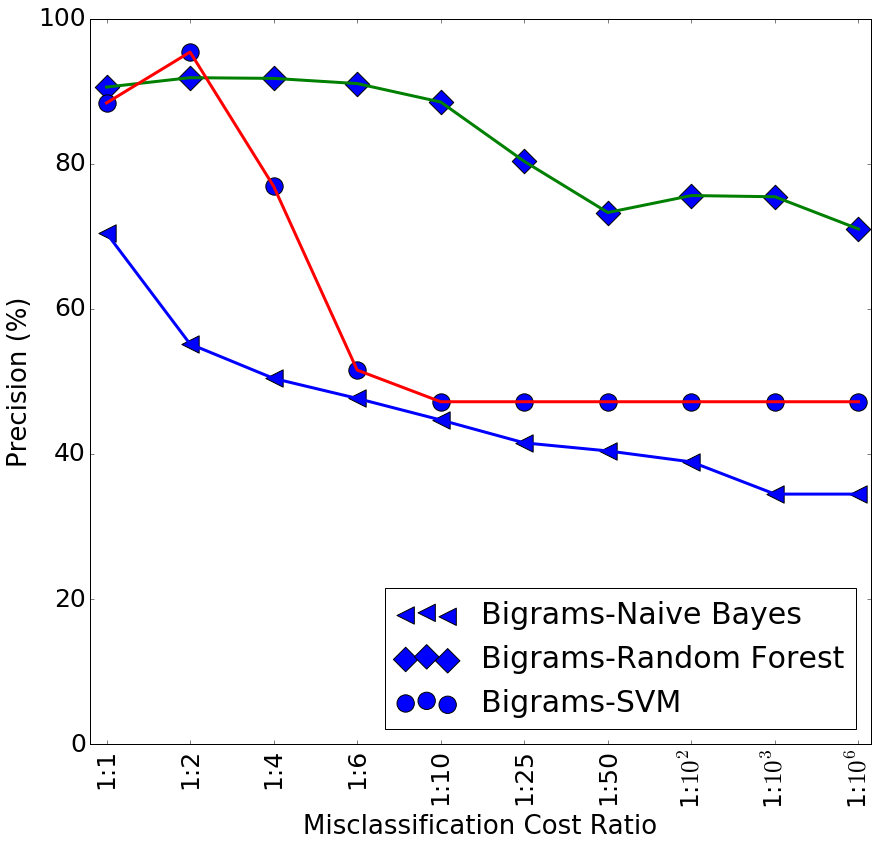

In [108]:
plot_image(axis_costs, precision_avg_normalized, title="PRECISION", ylim = [0., 100], 
           xlim = cxlim, colors="rgbmyc", models=pipes, name="precision", labels = labels, ylabel="Precision (%)",
           loc ="lower right", markers="<Do|", pattern="(.*Bigram.*(Bayes|SVM|.*Forest)|None_Baseline)")